## Introduction

For our project, we were tasked with using datasets from the Western Pennsylvania Regional Data Center in order to come up with a "best neighborhood" via a matric of our choosing. After discussing, we decided to focus on the saftey of each neighborhood, as we all agreed that it is important to live in a safe neighborhood. We considered doing other metrics such as quality of education and acccess to food, but ended up going with saftey as the main metric to focus on, as much of the datasets on the WPRDC are directly related to saftey.

## The Metrics

### Metric 1: Arrest Rates

In order to measure saftey, one metric that we can look at is the arrest data and how frequent arrests are in each neighborhood. Generally a neighborhood with lower arrest rates would be safer. From the Western Pennsylvania Regional Data Center, we can use both the arrest data dataset provided by the Pittsburgh police and the 2020 census dataset provided by the 2020 census for the neighborhood populations.

To fairly measure this metric, we need both the arrest data and the population data in order to look at the rate of crime rather than just the raw arrest numbers. That way, neighborhoods can be compared relatively, and we won't have a scenario where all the best neighborhoods are just the smallest and all the worst ones are the largest, as they would have lower and higher arrest rates respectively.

First, we will import all the necessary libraries in order to read, manipulate and display the data. Then we will read both of the datasets into corresponding data frames.

In [1]:
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

# read in arrest data
arr = pd.read_csv("./Arrests_Analysis/ArrestDataset.csv", sep=",")
#read in population data
pop = pd.read_csv("NeighborhoodPopulation.csv", sep=",")

FileNotFoundError: [Errno 2] No such file or directory: 'ArrestDataset.csv'

Next, we will create a 2 dictionaries. One for a neighborhood-population realtion and one for a neighborhood-number of offenses relation. For each of them, we will itterate through the corresponding dataframe and populate the dictionary with the neighborhood as the key. The value pair for population is the 2020 total population for that neighborhood, and for arrests we just incriment that neighborhood by one in order to increase the count of arrests.



In [ ]:
#define dict for populations
population = {}
#iterate and assign population to each neighborhood
for index,row in pop.iterrows():
    population[row["Neighborhood"]] = row["2020_Total_Population"]
    
#define dict for offenses
offenses =  defaultdict(int)
#iterate and assign # of offenses to each neighborhood
for index,row in arr.iterrows():
    offenses[row["INCIDENTNEIGHBORHOOD"]] += 1

Next we will define a set of neighborhoods that are contained within our population dataset that aren't contained in our arrest dataset. This is to ensure that we only look at neighborhoods that we have a well defined population for, and don't try to access something that doesn't exist within the arrest dataset.

In [ ]:
#create sets of neighborhoods
arr_neighborhoods = set(arr['INCIDENTNEIGHBORHOOD'])
pop_neighborhoods = set(pop['Neighborhood'])
#get missing neighborhoods by set difference
missing_neighborhoods = pop_neighborhoods - arr_neighborhoods

Now that we fully prepared our two datasets, we can create a crimerate dictionary to map the crimerate relative to population to each neighborhood. We will then sort that into a list.

In [ ]:
#make crimerate dict
crimerate = {}
#iterate through population
for key in population:
    #make sure we are only accessing neighborhoods in both datasets
    if key not in (missing_neighborhoods):
        #calculate crime rate for each neighborhood
        crimerate[key] = offenses[key] / population[key]

#sort by crimerate
sorted_crimerate = sorted(crimerate.items(), key=lambda x: x[1])

Looking into the crime rate of each neighborhood, we want to make sure that we're getting values that make sense. The only values that don't make sense are the ones with the highest arrest rates, much higher than 1 arrest per person, which is unrealistic. This could be due to a variety of reasons, the recency of the arrest data, the way neighborhood regions are divided beween datasets, small populations in neighborhoods or more. Luckily, that is only true of the neighborhoods with the highest arrest rate, which we are not interested in. We will avoid this by examaning only the top contendors later.

In [ ]:
for key, value in sorted_crimerate:
    print(f"Neighborhood: {key}, Crime Rate: {value}", "pop: ", population[key])

Now, we will create a dataframe using our sorted crimerate list, with a coulmn for neighborhood name and one for the crime rate we jusr calculated. At the same time, we will make another dataframe of the 10 neighborhoods with the lowest crimerate for easier visualization.

In [ ]:
#make crimerate dataframe
crimerate_df = pd.DataFrame(sorted_crimerate, columns=['Neighborhood', 'Crime Rate'])
#make top 10 neighborhoods by crimerate dataframe
top_10_neighborhoods = crimerate_df.sort_values(by='Crime Rate', ascending=True).head(10)

Now we will vizualize the results of our data exploration using matplotlib. Looking at all of the neighborhoods at once is overwhelming, as the outlier data mentioned above makes the data hard to see, so we can cut off the last 30 neighborhoods to get a feel for the bulk of the data, and see those neighborhood's names easier.

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(crimerate_df['Neighborhood'], crimerate_df['Crime Rate'], color='skyblue')
plt.xlabel('Neighborhood')
plt.ylabel('Crime Rate')
plt.title('Top 10 Neighborhoods by Lowest Crime Rate in Pittsburgh')
plt.xticks(rotation=45, ha='right')
plt.show()

Cutting off the bottom 30 lets us see that most neighborhoods lie below 30%

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(crimerate_df.head(59)['Neighborhood'], crimerate_df.head(59)['Crime Rate'], color='skyblue')
plt.xlabel('Neighborhood')
plt.ylabel('Crime Rate')
plt.title('Top 10 Neighborhoods by Lowest Crime Rate in Pittsburgh')
plt.xticks(rotation=45, ha='right')
plt.show()

Now let's just look at the top 10 neighborhoods


In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(top_10_neighborhoods['Neighborhood'], top_10_neighborhoods['Crime Rate'], color='skyblue')
plt.xlabel('Neighborhood')
plt.ylabel('Crime Rate')
plt.title('Top 10 Neighborhoods by Lowest Crime Rate in Pittsburgh')
plt.xticks(rotation=45, ha='right')
plt.show()

We can see from the bar graph that the neighborhood that has the lowest number of arrests proportional to the population of the neighborhood is Central Northside.

# RYLAN'S SECTION

In [ ]:
import pandas as pd
import geopandas
%matplotlib inline

fire_incidents = pd.read_csv("Fire_Incidents.csv")

#Seperating different fields
incident_description = fire_incidents["type_description"]

cities = fire_incidents["address"]

#City names are present after the comma in the address, so I split the address the comma,
#grabbed the second section, and then split by space and grabbed the second section
for i in range(len(cities)):
    city = (cities.iloc[i]).split(",")[1]
    city = city.split(" ")[1]
    cities.at[i] = city
    
#counts unique call numbers in each neighborhood
neighborhood_fires = fire_incidents.groupby('neighborhood').nunique()['call_no']


neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp") # read in the shapefile
neighborhoods.plot() # plot the geopandas dataframe

In [ ]:
#Time to merge number of fires with neighborhoods
fires_map = neighborhoods.merge(neighborhood_fires, how='left', left_on='hood', right_on='neighborhood')
#steps_map[['hood', 'call_no', 'geometry']]

In [ ]:
fires_map.plot(column='call_no',
               cmap='OrRd',
               edgecolor="white",
               legend=True,
               legend_kwds={'label': "Number of Fires"},
               figsize=(15,10)
              )

In [ ]:
#plot of 20 safest neighborhoods
least_neighborhoods = neighborhood_fires.sort_values().head(20)
least_fires_map = neighborhoods.merge(least_neighborhoods, how='left', left_on='hood', right_on='neighborhood')

#List the 20 safest neighborhoods
print(least_neighborhoods)

In [ ]:
least_fires_map.plot(column='call_no',
               cmap='Blues',
               edgecolor="white",
               legend=True,
               legend_kwds={'label': "Number of Fires"},
               figsize=(15,10),
               missing_kwds={"color" : "lightgrey"}
              )

# Now Considering Population - Part 2

In [ ]:
#Next, consider population in fire map
neighborhood_population = pd.read_csv("../NeighborhoodPopulation.csv")

#Fix some of the mismatched neighborhood names
neighborhood_population.at[15, "Neighborhood"] = "Central Business District"
neighborhood_population.at[73, "Neighborhood"] = "Spring Hill-City View"

import numpy as np
#print(np.in1d(neighborhood_population["Neighborhood"].unique(), fire_incidents["neighborhood"].unique()) )

#Now diving number of population by number of fires
for i in range(len(neighborhood_population["Neighborhood"])):
    if (np.isin(neighborhood_population.at[i, "Neighborhood"], fire_incidents["neighborhood"].unique() )):
        neighborhood_name = neighborhood_population.at[i, "Neighborhood"]
        neighborhood_pop = neighborhood_population.at[i, "2010_Total_Population"]
        fires_map_index = fires_map[fires_map["hood"]==neighborhood_name].index[0]
        
        fires_map.at[fires_map_index, "call_no"] = neighborhood_pop / fires_map.at[fires_map_index, "call_no"]
print(fires_map["call_no"].sort_values())

In [ ]:
fires_map.plot(column='call_no',
               cmap='OrRd',
               edgecolor="white",
               legend=True,
               legend_kwds={'label': "Number of Fires"},
               figsize=(15,10)
              )

In [ ]:
#plot of 20 safest neighborhoods
least_fires_map = fires_map.copy(deep=True)
least_fires_map.sort_values(by="call_no", inplace=True, ignore_index=True, ascending=False)
least_fires_map.loc[20:, "call_no"] = np.NaN

print(least_fires_map["call_no"].head(25))

#List the 10 safest neighborhoods

In [ ]:
least_fires_map.plot(column='call_no',
               cmap='Blues',
               edgecolor="white",
               legend=True,
               legend_kwds={'label': "Number of Fires"},
               figsize=(15,10),
               missing_kwds={"color" : "lightgrey"}
              )

# Now Looking at Different Graphs

In [ ]:
fires_map.index = fires_map["hood"]
fires_map.sort_values(by="call_no", inplace=True)
fires_map[["call_no", "hood"]].plot(kind="barh", title="Chance of fire (People/Fire)")
print(fires_map["call_no"])

In [ ]:
least_fires_map.dropna(inplace=True)
least_fires_map.index = least_fires_map["hood"]
least_fires_map[["call_no", "hood"]].plot(kind="barh", title="Chance of fire (People/Fire)")

# In terms of a chance of fire below are the five best options
* Westwood with 114 people per fire
* Morningside with 105 people per fire
* Regent Square with 103 people per fire
* Squirrel Hill North with 87 people per fire
* Swisshelm Park with 85 people per fire

## Evan's section

## Non-traffic violation
This dataset shows the incidents that happen in different neighborhoods. I basically measure which neighborhood has the most and least incident and the average age of some neighborhoods that happens incidents the most. I will also list some offenses that happen the most.

In [2]:
import pandas as pd

In [20]:
violation=pd.read_csv("non-traffic.csv")

In [21]:
violation.head(5)

,_id,PK,CCR,GENDER,RACE,AGE,CITEDTIME,INCIDENTLOCATION,OFFENSES,NEIGHBORHOOD,ZONE,INCIDENTTRACT,COUNCIL_DISTRICT,PUBLIC_WORKS_DIVISION,X,Y
0,1,1078081,16157849,M,B,29.0,2016-08-22T23:45:00,"200 Block N DITHRIDGE ST PITTSBURGH, PA",5503(a)(2) DISORDERLY CONDUCT - UNREASONABLE N...,North Oakland,4,507,8.0,3.0,-79.951692,40.449311
1,2,1078082,16157849,M,W,21.0,2016-08-22T23:45:00,"200 Block N DITHRIDGE ST PITTSBURGH, PA",5503(a)(2) DISORDERLY CONDUCT - UNREASONABLE N...,North Oakland,4,507,8.0,3.0,-79.951692,40.449311
2,3,1078083,16159579,NaN,NaN,NaN,2016-08-25T11:10:00,"NORTH PARK PITTSBURGH, PA",5505 Public Drunkenness,Allegheny Center,1,2204,NaN,NaN,NaN,NaN
3,4,1078084,16159780,M,B,22.0,2016-08-25T16:42:00,"7200 Block FRANKSTOWN AV PITTSBURGH, PA","6501(a)(1) Scattering Rubbish; Any waste, dang...",Homewood South,5,1303,9.0,2.0,-79.896254,40.457329
4,5,1078085,16161591,F,W,22.0,2016-08-28T00:58:00,"6100 Block BERLIN WY PITTSBURGH, PA",5503(a)(2) DISORDERLY CONDUCT - UNREASONABLE N...,Upper Lawrenceville,2,1011,7.0,2.0,-79.946664,40.485403


In [22]:
violation.drop(columns=['_id','PK','CCR','CITEDTIME','INCIDENTLOCATION','ZONE','INCIDENTTRACT',
                        'COUNCIL_DISTRICT','PUBLIC_WORKS_DIVISION','X','Y'])

,GENDER,RACE,AGE,OFFENSES,NEIGHBORHOOD
0,M,B,29.0,5503(a)(2) DISORDERLY CONDUCT - UNREASONABLE N...,North Oakland
1,M,W,21.0,5503(a)(2) DISORDERLY CONDUCT - UNREASONABLE N...,North Oakland
2,NaN,NaN,NaN,5505 Public Drunkenness,Allegheny Center
3,M,B,22.0,"6501(a)(1) Scattering Rubbish; Any waste, dang...",Homewood South
4,F,W,22.0,5503(a)(2) DISORDERLY CONDUCT - UNREASONABLE N...,Upper Lawrenceville
...,...,...,...,...,...
15636,M,B,41.0,601.08 (a) Open Container Law,NaN
15637,M,B,33.0,601.16(b)(1)(a) Any Person who urinates or def...,NaN
15638,M,B,33.0,5505 Public Drunkenness,NaN
15639,M,B,33.0,5503(a)(3) DISORDERLY CONDUCT - OBSCENE LANG/GEST,NaN


---

In [23]:
violation['NEIGHBORHOOD'].value_counts()

South Side Flats             3397
Central Business District    1995
Central Oakland               659
North Shore                   576
Carrick                       441
                             ... 
St. Clair                       3
Chartiers City                  3
Outside State                   2
Mt. Oliver Boro                 2
Outside County                  2
Name: NEIGHBORHOOD, Length: 97, dtype: int64

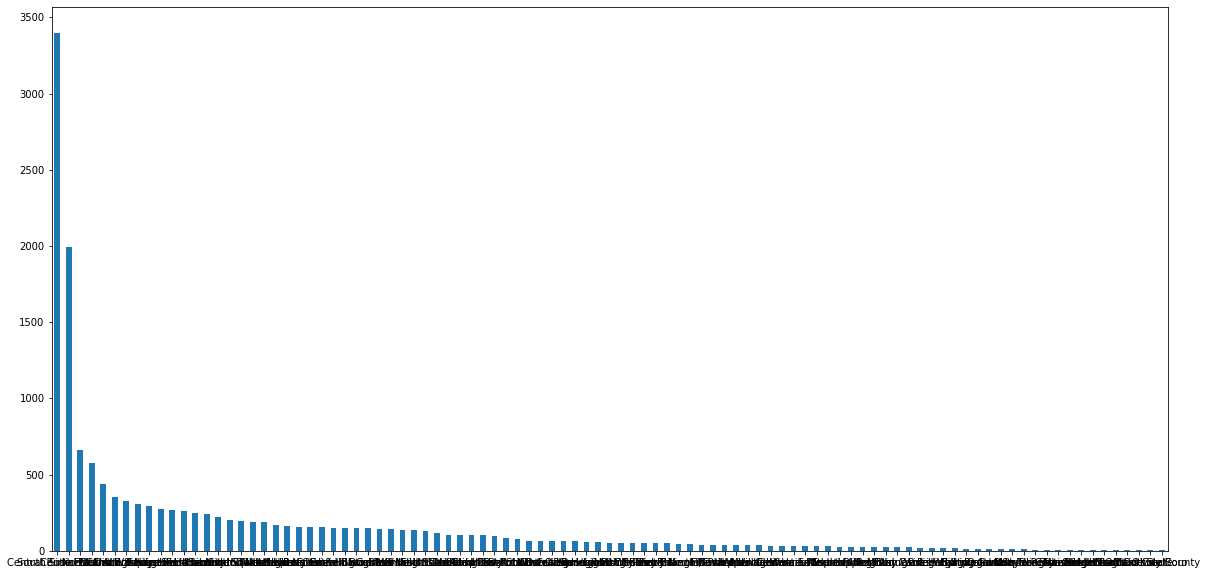

In [24]:
violation['NEIGHBORHOOD'].value_counts().plot(kind='bar', rot=0, figsize=(20,10));

In [25]:
violation['NEIGHBORHOOD'].value_counts().head(10)

South Side Flats             3397
Central Business District    1995
Central Oakland               659
North Shore                   576
Carrick                       441
East Allegheny                355
Mount Washington              327
Brookline                     310
Shadyside                     297
Hazelwood                     277
Name: NEIGHBORHOOD, dtype: int64

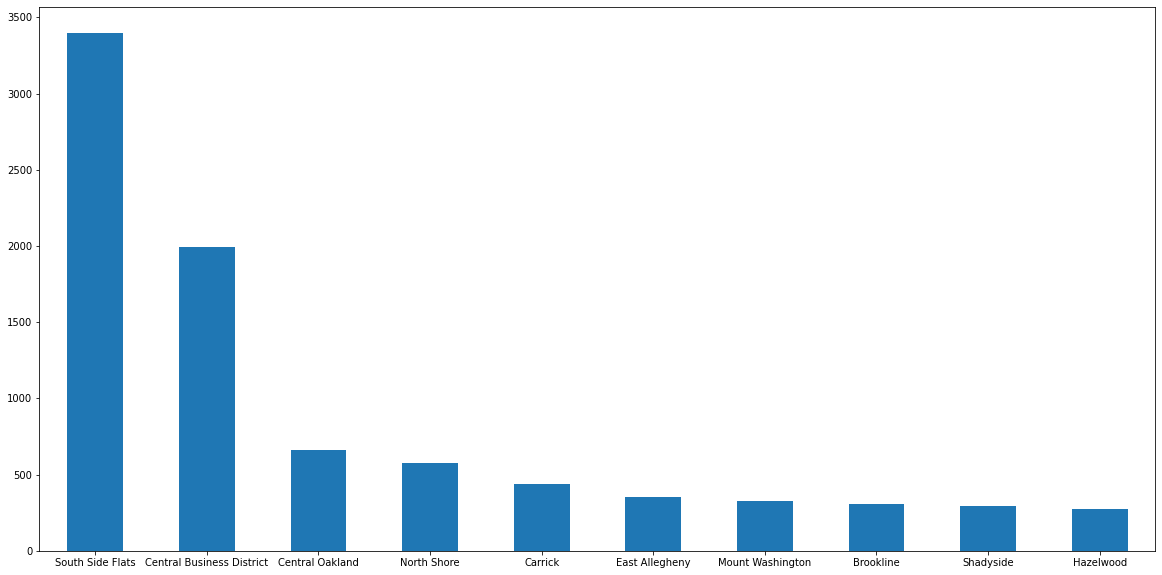

In [41]:
violation['NEIGHBORHOOD'].value_counts().head(10).plot(kind='bar', rot=0, figsize=(20,10));

In [20]:
violation['NEIGHBORHOOD'].value_counts().tail(10)

Arlington Heights          7
Summer Hill                7
Swisshelm Park             6
Ridgemont                  4
Mt. Oliver Neighborhood    4
St. Clair                  3
Chartiers City             3
Outside State              2
Mt. Oliver Boro            2
Outside County             2
Name: NEIGHBORHOOD, dtype: int64

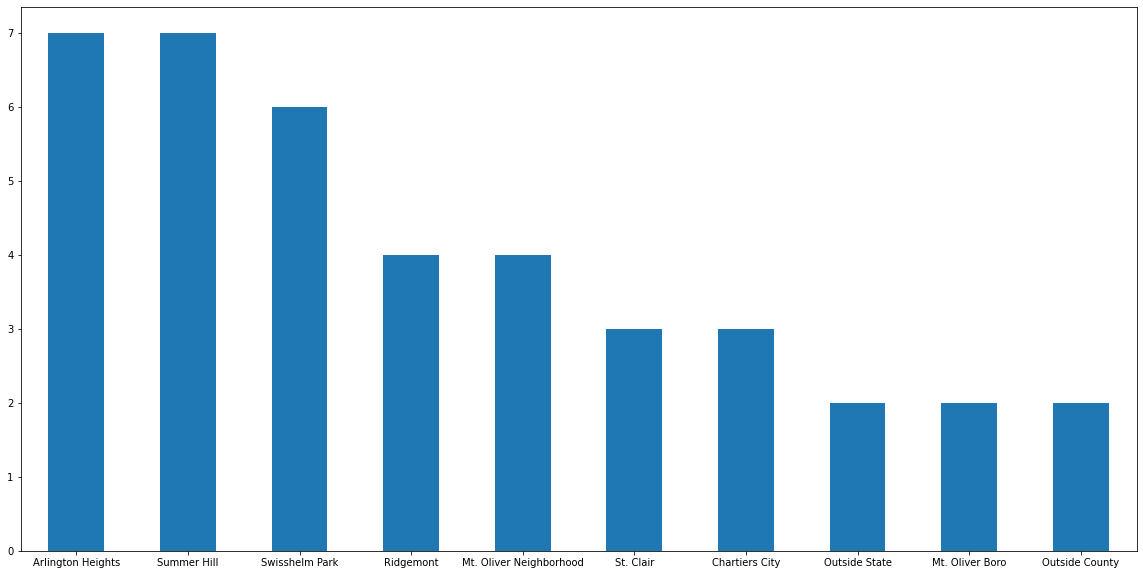

In [40]:
violation['NEIGHBORHOOD'].value_counts().tail(10).plot(kind='bar', rot=0, figsize=(20,10));

---

In [5]:
violation['AGE'].mean()

33.02735855115279

In [14]:
query_mask = violation['NEIGHBORHOOD']== "South Side Flats"
south=violation[query_mask]
south['AGE'].mean()

27.606203840472674

In [53]:
query_mask2 = violation['NEIGHBORHOOD']== "Central Business District"
central=violation[query_mask2]
central['AGE'].mean()

38.73104145601618

In [59]:
query_mask3 = violation['NEIGHBORHOOD']== "Central Oakland"
centralO=violation[query_mask3]
centralO['AGE'].mean()

23.65045592705167

In [56]:
query_mask4 = violation['NEIGHBORHOOD']== "North Shore"
north=violation[query_mask4]
north['AGE'].mean()

30.852430555555557

In [5]:
age = [['All neighborhood', 33.027],['South Side Flats', 27.606],['Central Business District', 38.731], 
       ['Central Oakland', 23.650], ['North Shore', 30.852]]
df=pd.DataFrame(age, columns=['neighborhood','mean value'])
df

,neighborhood,mean value
0,All neighborhood,33.027
1,South Side Flats,27.606
2,Central Business District,38.731
3,Central Oakland,23.650
4,North Shore,30.852


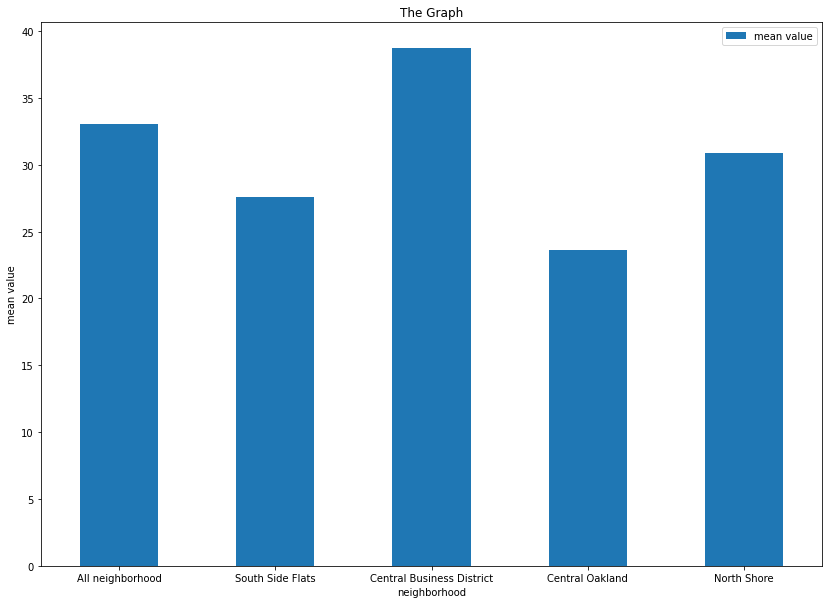

In [18]:
df.plot.bar(x='neighborhood', y='mean value', xlabel='neighborhood', ylabel='mean value', title='The Graph', 
            rot=0, figsize=(14,10));

---

In [26]:
violation['OFFENSES'].value_counts().head(5)

5505 Public Drunkenness                                                                   3081
2709(a)(1) Harassment by Physical Contact, or Attempts or Threats                         1519
627.02(b)(i) Possessing a small amount of marijuana                                       1262
5503(a)(1) DISORDERLY CONDUCT - ENGAGE IN FIGHTING                                        1260
601.16(b)(1)(a) Any Person who urinates or defecates in, on, or about any public place    1254
Name: OFFENSES, dtype: int64

#### Top 5 offenses:
* Public Drunkeness
* Harassment by Physical Contact
* Possessing a small amount of marijuana
* Engage in fighting
* Urination and defecation in any public place

In [36]:
top = [['Public Drunkness', 3081],['Harassment by physical contact', 1519],['Possessing marijuana', 1262], 
       ['Engaging in fighting', 1260], ['Urination and defecation in public', 1254]]
df2=pd.DataFrame(top, columns=['violation','count'])
df2

,violation,count
0,Public Drunkness,3081
1,Harassment by physical contact,1519
2,Possessing marijuana,1262
3,Engaging in fighting,1260
4,Urination and defecation in public,1254


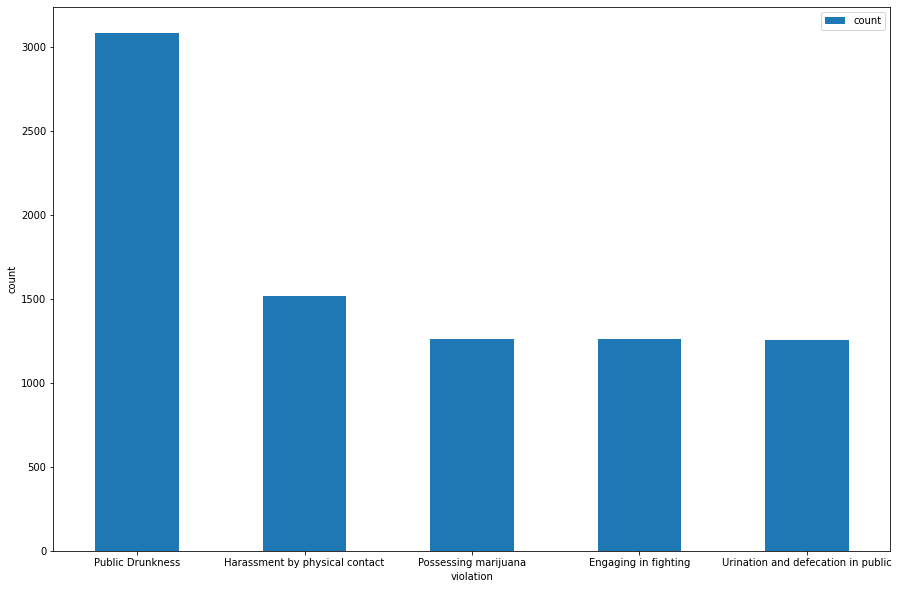

In [42]:
df2.plot.bar(x='violation', y='count', xlabel='violation', ylabel='count', rot=0, figsize=(15,10))

---

### Best Neighborhood: Mt.Oliver Boro

### Conclusion:
The reason I choose Mt.Oliver Boro as the best neighborhood is simply because it has the least incidents out of 97 neighborhoods. By the analysis, it's likely assuming that the fewer younger people the neighborhood has, the fewer incidents would happen. The most offensive is public drunkness, so the neighborhood has fewer bars and nightlife will also likely be more peaceful.
